In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
from PIL import Image
import os
import time
import cv2
from skimage import segmentation
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import imageio

In [2]:
train_folder = "./Dataset/Train-Labels/"
test_folder = "./Dataset/Test-Labels/"
images_folder = "./Dataset/Images/"

In [3]:
def getCities(folder):
    return [name for name in os.listdir(folder)
            if os.path.isdir(os.path.join(folder, name))]


In [4]:
def getData(folder):
    images = list()
    images_grayscale = list()
    src = list()
    cities = getCities(folder);
    for city in cities:
        img1 = images_folder + "/" + city + "/pair/img1.png"
        img2 = images_folder + "/" + city + "/pair/img2.png"
        gt = folder + "/" + city + "/cm/cm.png"
        src.append([img1, img2, gt])
        image1, image2, image3 = cv2.imread(img1), cv2.imread(img2), cv2.imread(gt)
        rgb1,rgb2 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB),cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
        gray1,gray2,gray3 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY),cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY),cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
        images.append(np.array([rgb1,rgb2,image3]))
        images_grayscale.append(np.array([gray1,gray2,gray3]))
    return src, images,images_grayscale

In [5]:
train_data_src, train_data,train_data_grayscale = getData(train_folder)

In [6]:
test_data_src, test_data,test_data_grayscale = getData(test_folder)

In [7]:
def printData(images,source):
    for city_data,src in zip(images,source):
        fig,ax = plt.subplots(1,3,figsize=(15,15))
        city = src[0].split('/')[-3]
        plt.title(city)
        ax[0].imshow(city_data[0])
        ax[1].imshow(city_data[1])
        ax[2].imshow(city_data[2])

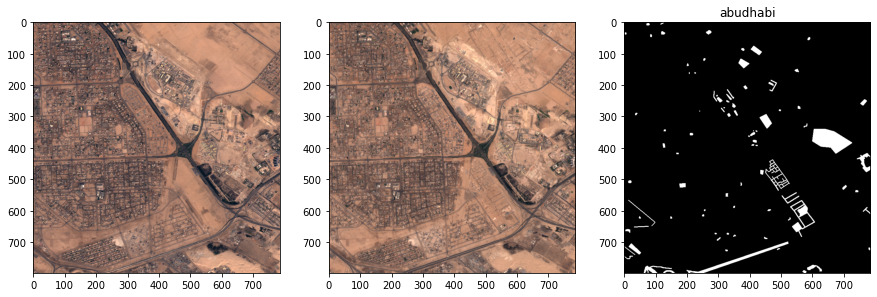

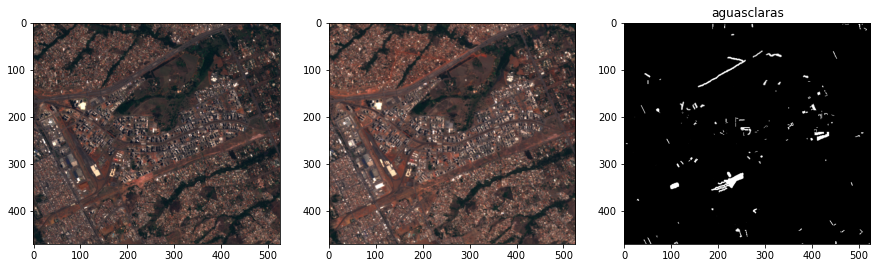

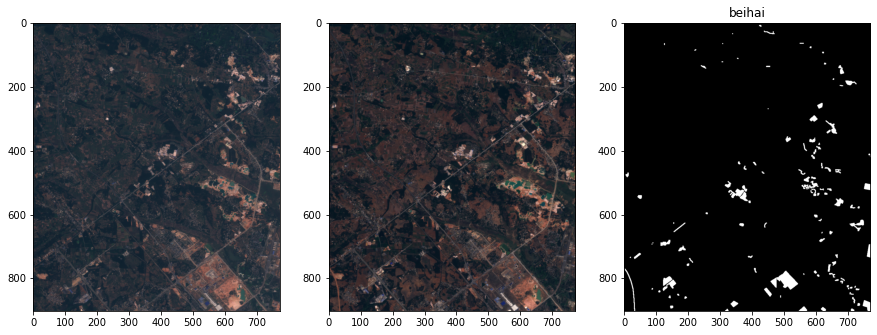

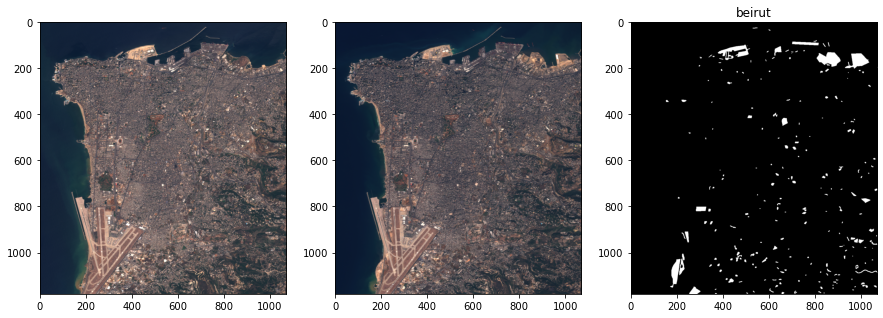

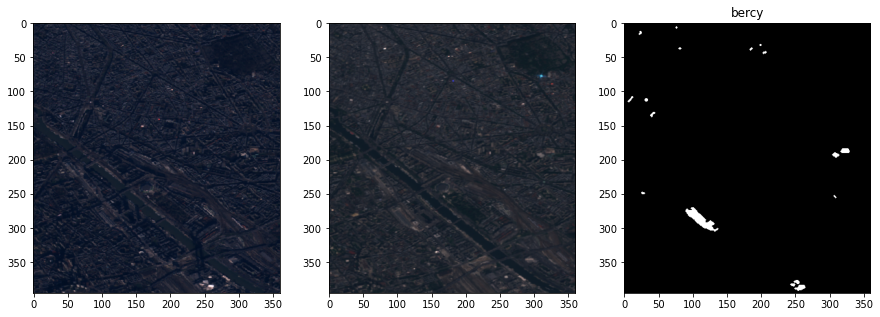

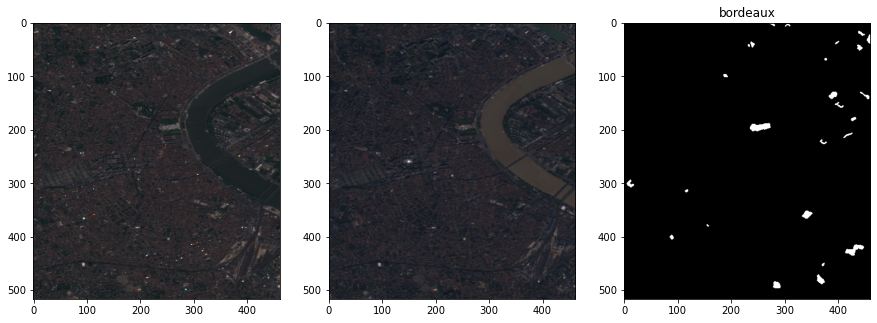

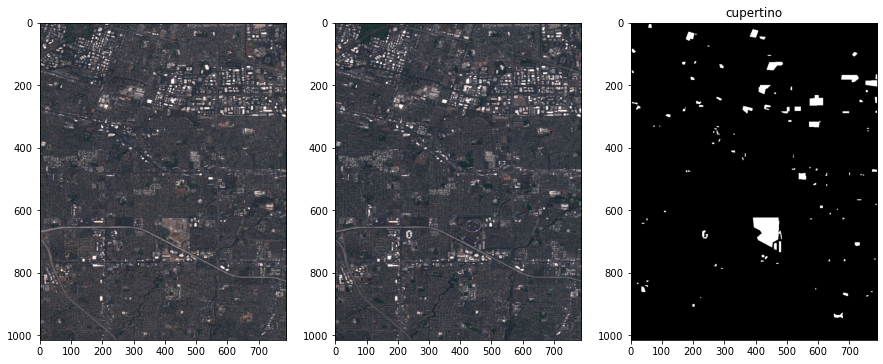

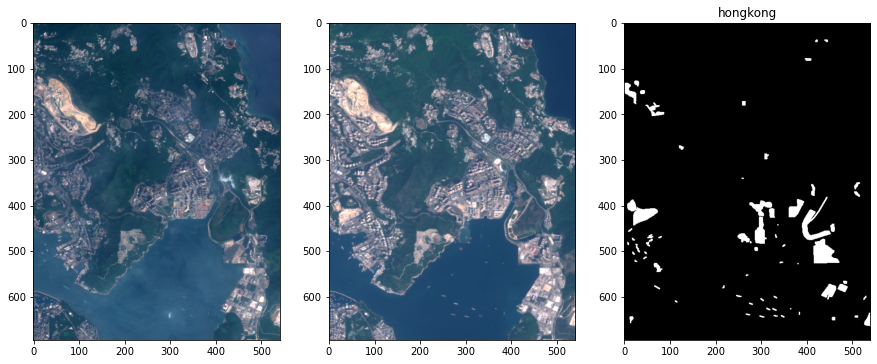

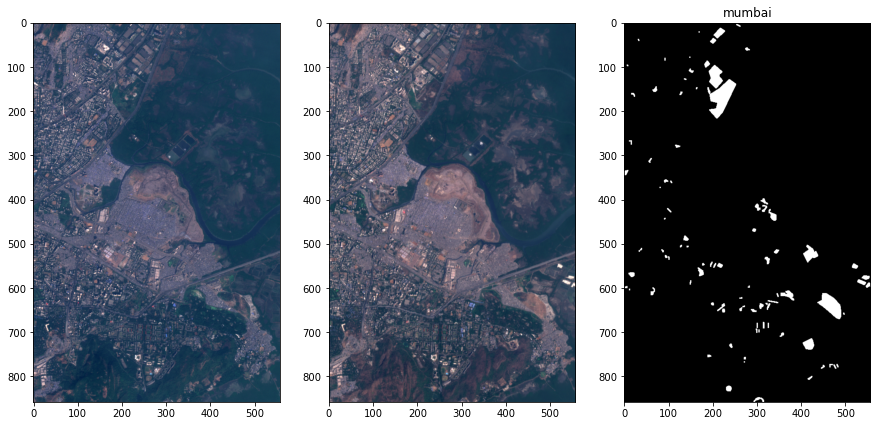

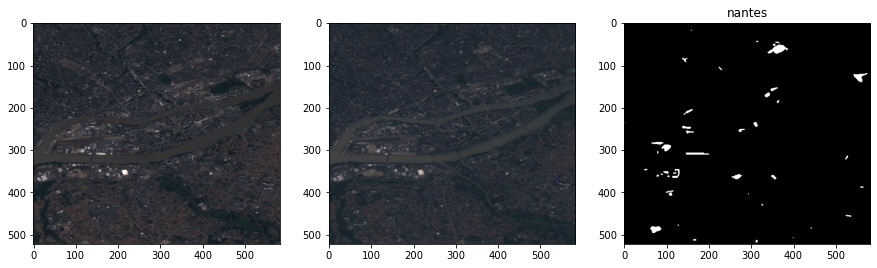

In [8]:
printData(train_data[0:10],train_data_src[0:10])

In [9]:
print(train_data[0][0].shape,train_data[0][1].shape,train_data[0][2].shape)

(799, 785, 3) (799, 785, 3) (799, 785, 3)


In [10]:
print(train_data_grayscale[0][0].shape,train_data_grayscale[0][1].shape,train_data_grayscale[0][2].shape)

(799, 785) (799, 785) (799, 785)


In [11]:
def generate_data(train_data,train_data_grayscale):
  train_x_rgb,test_x_rgb,train_y_rgb,test_y_rgb = [list() for i in range(4)]
  train_x_gray,train_y_gray,test_x_gray,test_y_gray = [list() for i in range(4)]
  for images in zip(train_data,train_data_grayscale):
    rgb_list, gray_list = images
    rgb_proc, gray_proc = [],[]
    for img_rgb,img_gray in zip(rgb_list,gray_list):
      img_rgb_proc = tf.image.resize(img_rgb/255, (112, 112), method='nearest')
      img_gray_proc = tf.image.resize(np.atleast_3d(img_gray)/255, (112, 112), method='nearest')
      rgb_proc.append(img_rgb_proc)
      gray_proc.append(img_gray_proc)
    pre_rgb, post_rgb,gt_rgb = rgb_proc
    pre_gray,post_gray,gt_gray = gray_proc
    rgb_x = tf.concat([pre_rgb,post_rgb],axis=-1)
    gray_x = tf.concat([pre_gray,post_gray],axis=-1)
    train_x_rgb.append(rgb_x)
    train_y_rgb.append(gt_rgb)
    train_x_gray.append(gray_x)
    train_y_gray.append(gt_gray)
  return np.array(train_x_rgb),np.array(train_y_rgb),np.array(train_x_gray),np.array(train_y_gray)

In [12]:
train_x_rgb,train_y_rgb,train_x_gray,train_y_gray = generate_data(train_data,train_data_grayscale)

In [13]:
print(train_x_rgb.shape,train_y_rgb.shape,train_x_gray.shape,train_y_gray.shape)

(14, 112, 112, 6) (14, 112, 112, 3) (14, 112, 112, 2) (14, 112, 112, 1)


In [14]:
test_x_rgb, test_y_rgb,test_x_gray,test_y_gray = generate_data(test_data,test_data_grayscale)

In [15]:
print(test_x_rgb.shape,test_y_rgb.shape,test_x_gray.shape,test_y_gray.shape)

(10, 112, 112, 6) (10, 112, 112, 3) (10, 112, 112, 2) (10, 112, 112, 1)


In [16]:
print(train_x_rgb[0])
print(train_x_gray[0])

[[[0.30980392 0.25098039 0.2745098  0.54117647 0.42352941 0.35294118]
  [0.63921569 0.4627451  0.42352941 0.59215686 0.4627451  0.40784314]
  [0.41960784 0.31372549 0.30980392 0.51764706 0.38823529 0.32941176]
  ...
  [0.77254902 0.57254902 0.45490196 0.75686275 0.57254902 0.44313725]
  [0.82352941 0.60392157 0.48235294 0.80392157 0.59215686 0.4745098 ]
  [0.77647059 0.58039216 0.4627451  0.80784314 0.60784314 0.49019608]]

 [[0.69803922 0.50588235 0.43137255 0.63137255 0.45490196 0.36470588]
  [0.4745098  0.34509804 0.31372549 0.49411765 0.38823529 0.34509804]
  [0.5254902  0.39607843 0.39607843 0.59215686 0.49019608 0.41568627]
  ...
  [0.78823529 0.58431373 0.47843137 0.78823529 0.57647059 0.46666667]
  [0.76862745 0.56470588 0.4627451  0.76470588 0.55686275 0.44313725]
  [0.76078431 0.56470588 0.45490196 0.72156863 0.51764706 0.41568627]]

 [[0.49019608 0.36078431 0.32941176 0.51764706 0.37254902 0.30980392]
  [0.61568627 0.41568627 0.34901961 0.49019608 0.36078431 0.30196078]
  [0

In [17]:
print(train_y_rgb[0])
print(train_y_gray[0])

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


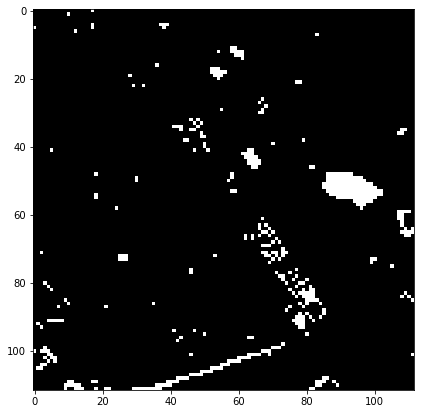

In [18]:
plt.rcParams["figure.figsize"] = (7,7)
plt.imshow(train_y_rgb[0])

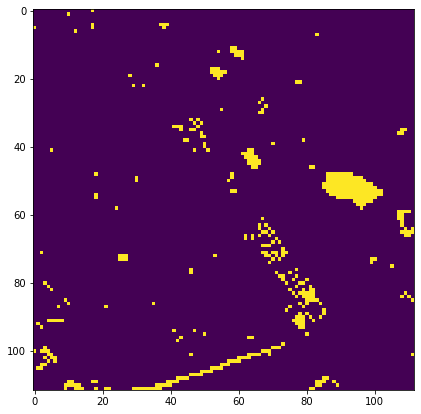

In [19]:
plt.rcParams["figure.figsize"] = (7,7)
plt.imshow(train_y_gray[0][:,:,0])

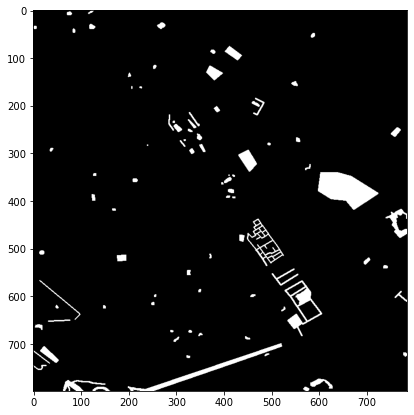

In [20]:
plt.rcParams["figure.figsize"] = (7,7)
plt.imshow(train_data[0][2])

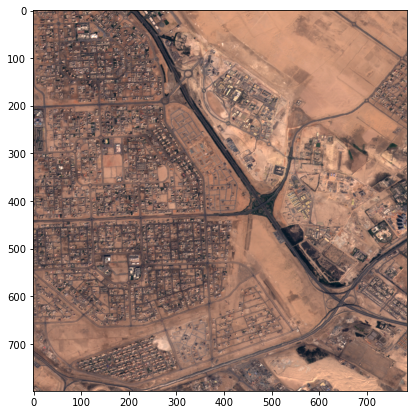

In [21]:
plt.rcParams["figure.figsize"] = (7,7)
plt.imshow(train_data[0][0])

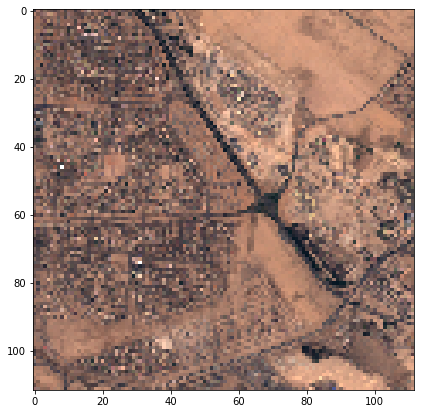

In [22]:
plt.rcParams["figure.figsize"] = (7,7)
plt.imshow(train_x_rgb[0][:,:,0:3])

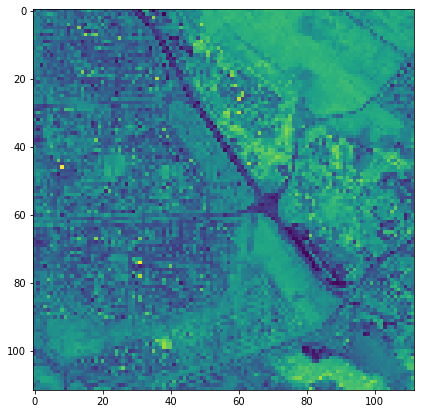

In [23]:
plt.rcParams["figure.figsize"] = (7,7)
plt.imshow(train_x_gray[0][:,:,0])

In [24]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
   
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [25]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    
                 3,   
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    return conv

In [26]:
def unet_model(input_size=(112, 112, 2), n_filters=16, n_classes=2):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], 16*n_filters, dropout_prob=0.3, max_pooling=False) 
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  4*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same',activation='sigmoid')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [27]:
img_height = 112
img_width = 112
num_channels = 2

In [28]:
unet = unet_model((img_height, img_width, num_channels))

In [29]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 16  304         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 112, 112, 2)  34          ['conv2d_18[0][0]']              
                                                                                                  
Total params: 2,160,898
Trainable params: 2,160,898
Non-trainable params: 0
__________________________________________________________________________________________________


In [30]:
def dice_loss_v2(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

    return 1 - numerator / denominator

In [31]:
unet.compile(optimizer='adam',
              loss=dice_loss_v2,
              metrics=['accuracy'])

In [32]:
EPOCHS = 100
VAL_SUBSPLITS = 5
BUFFER_SIZE = 100
BATCH_SIZE = 2

In [34]:
train_dataset_rgb = tf.data.Dataset.from_tensor_slices((train_x_rgb, train_y_rgb))
test_dataset_rgb = tf.data.Dataset.from_tensor_slices((test_x_rgb, test_y_rgb))

In [35]:
train_dataset_gray = tf.data.Dataset.from_tensor_slices((train_x_gray, train_y_gray))
test_dataset_gray = tf.data.Dataset.from_tensor_slices((test_x_gray, test_y_gray))

In [36]:
train_dataset = train_dataset_rgb.shuffle(14).batch(BATCH_SIZE)

In [37]:
model_history = unet.fit(train_x_gray,train_y_gray, epochs=EPOCHS,batch_size = BATCH_SIZE,validation_data=(test_x_gray,test_y_gray))

Epoch 1/100
7/7 [==============================] - 5s 325ms/step - loss: 0.9624 - accuracy: 0.7687 - val_loss: 0.9197 - val_accuracy: 0.9508
Epoch 2/100
7/7 [==============================] - 1s 210ms/step - loss: 0.9607 - accuracy: 0.9785 - val_loss: 0.9166 - val_accuracy: 0.9552
Epoch 3/100
7/7 [==============================] - 2s 223ms/step - loss: 0.9586 - accuracy: 0.8524 - val_loss: 0.9151 - val_accuracy: 0.2256
Epoch 4/100
7/7 [==============================] - 2s 235ms/step - loss: 0.9574 - accuracy: 0.2385 - val_loss: 0.9141 - val_accuracy: 0.1015
Epoch 5/100
7/7 [==============================] - 1s 202ms/step - loss: 0.9539 - accuracy: 0.2784 - val_loss: 0.9111 - val_accuracy: 0.1202
Epoch 6/100
7/7 [==============================] - 1s 205ms/step - loss: 0.9504 - accuracy: 0.1550 - val_loss: 0.9053 - val_accuracy: 0.1144
Epoch 7/100
7/7 [==============================] - 1s 215ms/step - loss: 0.9428 - accuracy: 0.1163 - val_loss: 0.8902 - val_accuracy: 0.1750
Epoch 8/100
7

Epoch 59/100
7/7 [==============================] - 1s 176ms/step - loss: 0.5008 - accuracy: 0.0213 - val_loss: 0.8250 - val_accuracy: 0.0536
Epoch 60/100
7/7 [==============================] - 1s 200ms/step - loss: 0.4931 - accuracy: 0.0204 - val_loss: 0.8953 - val_accuracy: 0.0548
Epoch 61/100
7/7 [==============================] - 1s 170ms/step - loss: 0.4938 - accuracy: 0.0214 - val_loss: 0.8191 - val_accuracy: 0.0587
Epoch 62/100
7/7 [==============================] - 1s 177ms/step - loss: 0.4803 - accuracy: 0.0198 - val_loss: 0.8319 - val_accuracy: 0.0504
Epoch 63/100
7/7 [==============================] - 1s 178ms/step - loss: 0.4948 - accuracy: 0.0202 - val_loss: 0.8912 - val_accuracy: 0.0478
Epoch 64/100
7/7 [==============================] - 2s 229ms/step - loss: 0.4826 - accuracy: 0.0218 - val_loss: 0.8244 - val_accuracy: 0.0566
Epoch 65/100
7/7 [==============================] - 1s 184ms/step - loss: 0.4635 - accuracy: 0.0216 - val_loss: 0.8402 - val_accuracy: 0.0591
Epoch 

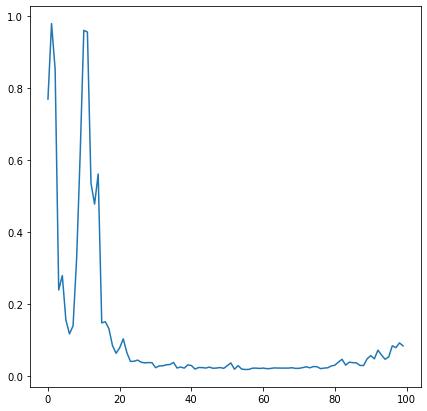

In [38]:
plt.plot(model_history.history["accuracy"])

In [39]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [40]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Pre','Input Post', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [41]:
def show_predictions(test_x_rgb,test_y_gray, num=1):
  count = 0
  for image, mask in zip(test_x_rgb,test_y_gray):
    pred_mask = unet.predict(image[np.newaxis,:,:,:])
    display([image[:,:,0:1],image[:,:,1:2] ,mask, create_mask(pred_mask)])
    count += 1
    if count>=num:
      break

1/1 [==============================] - 4s 4s/step


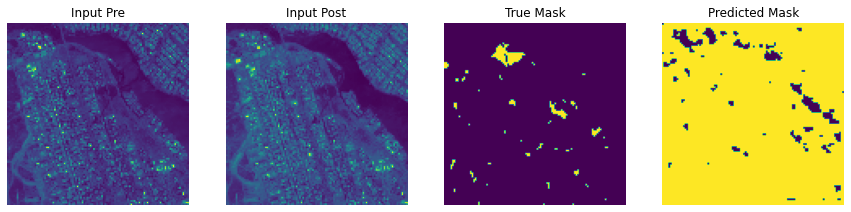

In [42]:
show_predictions(test_x_gray,test_y_gray,)

In [ ]:
unet.save('SAR_model')